In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
	sys.path.append(nb_dir)

In [2]:
import torch
import torch.nn as nn
from torch.optim.radam import RAdam

from general_utils import AttrDict
from reward_induced.models.reward_predictor_model import RewardPredictorModel
from reward_induced.models.decoder import ImageDecoder
from reward_induced.utils import *
from sprites_datagen.moving_sprites import MovingSpriteDataset, TemplateMovingSpritesGenerator
from sprites_datagen.rewards import *

from tqdm import trange
import matplotlib.pyplot as plt

/home/thisiswooyeol/anaconda3/envs/2024Spring/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=4,      # number of shapes per trajectory
        rewards=[ZeroReward],
    )

dataset = MovingSpriteDataset(spec)

In [4]:
# some hyperparameters
image_shape = (3, 64, 64)
n_frames = 20  # number of conditioning frames
T_future = 10  # number of future frames to predict rewards for
batch_size = 32

lr = 1e-3
n_iter = 2_000
log_interval = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train an ImageDecoder from complete images to reward-induced representation

In [5]:
RPM_PATH = 'complete_RPM_1e-3_1M.pth'

model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(RPM_PATH))

# with learned image encoder, decode reward-induced representations
encoder = model.image_encoder
decoder = ImageDecoder(image_shape)

In [6]:
loss_fn = nn.MSELoss()
optimizer = RAdam(decoder.parameters(), lr=lr)

In [7]:
def train_decoder(encoder, decoder, dataset, device, n_iter):
    # decoder should restore the original image from the reward-induced representation
    losses = []
    encoder.to(device).eval()
    decoder.to(device)
    print(f'[INFO] Train decoder on device: {device} ...')

    for itr in trange(n_iter):
        images, _ = generate_batch(dataset, batch_size, itr)
        images = images.to(device)
		
        # encode the images
        with torch.no_grad():
            encoded_repr = encoder(images).detach() 
        
        # decode the images
        decoded_images = decoder(encoded_repr)

        loss = loss_fn(decoded_images, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (itr+1) % log_interval == 0:
            print(f'[{itr+1} / {n_iter}] Reproduction loss: {loss.item()}')

    return losses

In [8]:
losses_decoder = train_decoder(encoder, decoder, dataset, device, n_iter)

[INFO] Train decoder on device: cuda ...


 10%|█         | 200/2000 [01:16<11:14,  2.67it/s]

[200 / 2000] Reproduction loss: 0.2696765959262848


 20%|██        | 400/2000 [02:38<10:53,  2.45it/s]

[400 / 2000] Reproduction loss: 0.24574890732765198


 30%|███       | 600/2000 [04:05<11:43,  1.99it/s]

[600 / 2000] Reproduction loss: 0.24482350051403046


 40%|████      | 800/2000 [05:36<08:50,  2.26it/s]

[800 / 2000] Reproduction loss: 0.24543315172195435


 50%|█████     | 1000/2000 [07:02<06:53,  2.42it/s]

[1000 / 2000] Reproduction loss: 0.24508890509605408


 60%|██████    | 1200/2000 [08:22<05:20,  2.50it/s]

[1200 / 2000] Reproduction loss: 0.24264270067214966


 70%|███████   | 1400/2000 [09:41<03:45,  2.66it/s]

[1400 / 2000] Reproduction loss: 0.2161809355020523


 80%|████████  | 1600/2000 [10:57<02:30,  2.66it/s]

[1600 / 2000] Reproduction loss: 0.17123451828956604


 90%|█████████ | 1800/2000 [11:59<01:11,  2.81it/s]

[1800 / 2000] Reproduction loss: 0.15681421756744385


100%|██████████| 2000/2000 [12:50<00:00,  2.60it/s]

[2000 / 2000] Reproduction loss: 0.14647439122200012


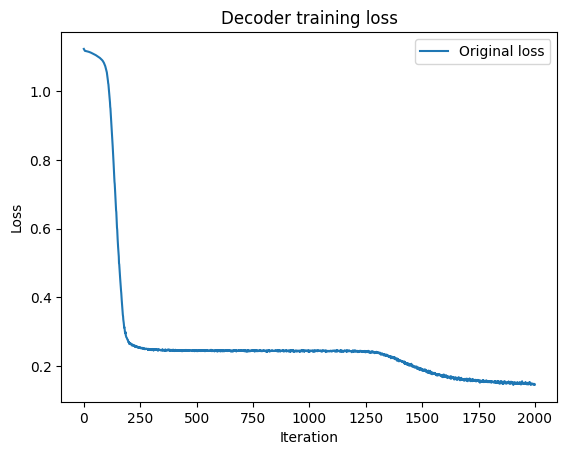

In [9]:
# Visualize the losses
plt.plot(losses_decoder, label='Original loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Decoder training loss')
plt.legend()
plt.show()

In [10]:
DECODER_PATH = 'complete_decoder_tanh_4K.pth'
torch.save(decoder.state_dict(), DECODER_PATH)

In [11]:
decoder = ImageDecoder(image_shape)
decoder.load_state_dict(torch.load(DECODER_PATH))  # test save and load

<All keys matched successfully>

# Decode the reward-induced representation

In [12]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=1,      # number of shapes per trajectory
        rewards=[VertPosReward, HorPosReward],
    )

generator = TemplateMovingSpritesGenerator(spec)
generator.SHAPES = ['tri_bottom']

In [13]:
from general_utils import make_image_seq_strip
import cv2

output = generator.gen_trajectory()
images = make_image_seq_strip([output['images'][None, :, None].repeat(3, axis=2).astype(np.float32)], \
                              sep_val=255.0).astype(np.uint8)

print(output['images'].shape)
cv2.imwrite('one_distractor.png', images[0].transpose(1, 2, 0))

print(output['rewards'])

(30, 64, 64)
{'vertical_position': array([0.5201178 , 0.5593974 , 0.598677  , 0.63795656, 0.67723614,
       0.7165157 , 0.7557953 , 0.7950749 , 0.8343544 , 0.873634  ,
       0.88708645, 0.8478069 , 0.8085273 , 0.7692477 , 0.72996813,
       0.69068855, 0.651409  , 0.6121294 , 0.5728498 , 0.53357023,
       0.49429068, 0.4550111 , 0.41573152, 0.37645194, 0.33717236,
       0.2978928 , 0.25861323, 0.21933365, 0.18005407, 0.1407745 ],
      dtype=float32), 'horizontal_position': array([0.5245881 , 0.55684334, 0.5890985 , 0.62135375, 0.6536089 ,
       0.6858641 , 0.7181193 , 0.7503745 , 0.7826297 , 0.8148849 ,
       0.84714013, 0.8793953 , 0.8883495 , 0.8560943 , 0.8238391 ,
       0.7915839 , 0.7593287 , 0.7270735 , 0.6948183 , 0.66256315,
       0.6303079 , 0.59805274, 0.5657975 , 0.53354234, 0.50128716,
       0.46903193, 0.43677676, 0.40452155, 0.37226635, 0.34001115],
      dtype=float32)}


### Decode vertical reward-induced representations with ImageDecoder

In [14]:
model_vertical = RewardPredictorModel(image_shape, n_frames, T_future)
model_vertical.load_state_dict(torch.load(RPM_PATH))

decoder_vertical = ImageDecoder(image_shape)
decoder_vertical.load_state_dict(torch.load(DECODER_PATH))

<All keys matched successfully>

In [15]:
images, rewards = generate_batch_gen(generator, 3)

images.shape

torch.Size([3, 30, 3, 64, 64])

In [16]:
loss_fn = nn.MSELoss()
optimizer = RAdam(model_vertical.parameters(), lr=5e-4)  # lr / 2

In [28]:
def finetune_RPM_single_reward(model, generator, loss_fn, optimizer, device, reward_type_list: list[str]):
	losses = []
	model.to(device)
	print(f'[INFO] Finetune RPM with {reward_type_list} reward on device: {device} ...')

	for itr in trange(n_iter):
		images, rewards = generate_batch_gen(generator, batch_size)
		
		# assume n_frames + T_future == len(images)
		pred_rewards = model(  # add batch dimension for images
			conditioning_frames=images[:, :n_frames].to(device), 
			future_frames=images[:, n_frames:].to(device),
			reward_type=reward_type_list
		)

		loss = 0
		for reward_type, pred_reward in pred_rewards.items():
			reward = torch.tensor(rewards[reward_type][:, n_frames:], 
						 dtype=torch.float32, device=device)
			loss += loss_fn(pred_reward, reward)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())
		if (itr+1) % log_interval == 0:
			print(f'[{itr+1} / {n_iter}] RPM loss: {loss.item()}')

	return losses

In [30]:
losses = finetune_RPM_single_reward(model_vertical, generator, loss_fn, optimizer, device, ['vertical_position'])

[INFO] Finetune RPM with ['vertical_position'] reward on device: cuda ...


  0%|          | 0/2000 [00:00<?, ?it/s]

 10%|█         | 201/2000 [00:41<05:55,  5.06it/s]

[200 / 2000] RPM loss: 3.6715049645863473e-05


 20%|██        | 401/2000 [01:22<05:09,  5.17it/s]

[400 / 2000] RPM loss: 2.6432195227243938e-05


 30%|███       | 600/2000 [02:03<05:03,  4.61it/s]

[600 / 2000] RPM loss: 2.73599180218298e-05


 40%|████      | 800/2000 [02:44<04:11,  4.77it/s]

[800 / 2000] RPM loss: 2.8432510589482263e-05


 50%|█████     | 1000/2000 [03:26<05:35,  2.98it/s]

[1000 / 2000] RPM loss: 2.8719905458274297e-05


 60%|██████    | 1200/2000 [04:13<03:11,  4.17it/s]

[1200 / 2000] RPM loss: 2.6961626645061187e-05


 70%|███████   | 1400/2000 [05:01<02:02,  4.89it/s]

[1400 / 2000] RPM loss: 2.6522500775172375e-05


 80%|████████  | 1601/2000 [05:43<01:18,  5.06it/s]

[1600 / 2000] RPM loss: 3.113248021691106e-05


 90%|█████████ | 1801/2000 [06:23<00:38,  5.23it/s]

[1800 / 2000] RPM loss: 2.832747486536391e-05


100%|██████████| 2000/2000 [07:02<00:00,  4.74it/s]

[2000 / 2000] RPM loss: 2.6749785320134833e-05


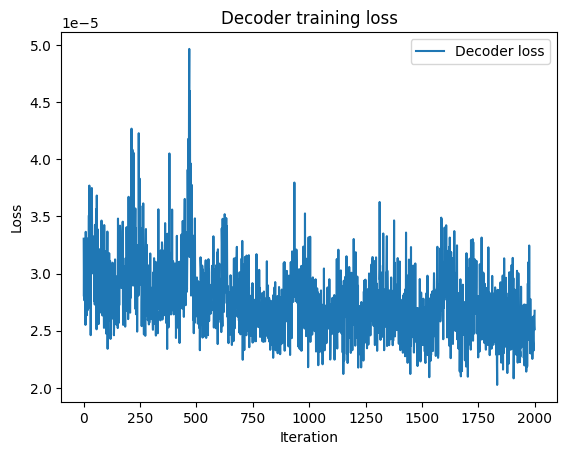

In [31]:
# Visualize the losses
plt.plot(losses, label='Decoder loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Decoder training loss')
plt.legend()
plt.show()

In [57]:
decoder_vertical.to(device).eval()
images, _ = generate_batch_gen(generator, 1)

with torch.no_grad():
    # encode the images
    encoded_repr = model_vertical.image_encoder(images[:, :n_frames].to(device))
    decoded_images = decoder_vertical(encoded_repr)

decoded_images = decoded_images.cpu().numpy()
decoded_images = make_image_seq_strip([decoded_images[0, None, :, None]], sep_val=255.0).astype(np.uint8)[0,0]
cv2.imwrite('vertical_decoded.png', decoded_images.transpose(2, 1, 0))

True

### Decode horizontal reward-induced representations with ImageDecoder